In [173]:
import pandas as pd
from scipy.spatial import distance
from math import sin, cos, sqrt, atan2, radians
import time
import shapely

from shapely.geometry import shape, Point
import shapely.wkt

In [384]:
permits = pd.read_csv('data/cleaned_permits.csv')

In [385]:
permits.shape

(7174, 15)

In [157]:
#please download one of the following two permits datasets

#permits = pd.read_csv('data/original_cleaned_permits_for_feature_engineering.csv') #<-- to follow along with my work, use this

#permits = pd.read_csv('data/cleaned_permits.csv') #<-- this data set has the additional 
    #half dozen entries I recovered on revision of my cleaning work. If I were to rework this, I'd use this dataset.

nypd2014_15 = pd.read_csv('../capstone_large_data_sets/nypd2014_15.csv')
nypd2015_16 = pd.read_csv('../capstone_large_data_sets/nypd2015_16.csv')
nypd2016_17 = pd.read_csv('../capstone_large_data_sets/nypd2016_17.csv')
nypd2017_18 = pd.read_csv('../capstone_large_data_sets/nypd2017_18.csv')
nypd2018_19 = pd.read_csv('../capstone_large_data_sets/nypd2018_19.csv')
nypd2019_20 = pd.read_csv('../capstone_large_data_sets/nypd2019_20.csv')

In [107]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125
2,BRONX,2823631,368,EAST 152 STREET,220586168,10455,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118
3,BROOKLYN,3429007,3410,FARRAGUT ROAD,321588215,11210,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944
4,BROOKLYN,3121674,1457,FLATBUSH AVENUE,321827163,11210,2022-05-11,CORPORATION,N,40.634773,-73.949721


In [158]:
nypd2014_15.head(1)

,cmplnt_num,cmplnt_fr_dt,law_cat_cd,boro_nm,addr_pct_cd,x_coord_cd,y_coord_cd,latitude,longitude
0,604271687,2015-03-01,FELONY,BRONX,48.0,1011779.0,246746.0,40.843901,-73.900505


In [159]:
nypd2015_16.head(1)

,cmplnt_num,cmplnt_fr_dt,law_cat_cd,boro_nm,addr_pct_cd,x_coord_cd,y_coord_cd,latitude,longitude
0,700078195,2016-06-10,FELONY,BRONX,45.0,1030139.0,244308.0,40.837133,-73.834164


In [160]:
nypd2016_17.head(1)

,cmplnt_num,cmplnt_fr_dt,law_cat_cd,boro_nm,addr_pct_cd,x_coord_cd,y_coord_cd,latitude,longitude
0,216044876,2017-01-01,FELONY,QUEENS,109.0,1032198.0,217060.0,40.762334,-73.826917


In [161]:
nypd2017_18.head(1)

,cmplnt_num,cmplnt_fr_dt,law_cat_cd,boro_nm,addr_pct_cd,x_coord_cd,y_coord_cd,latitude,longitude
0,954653095,2017-11-15,FELONY,QUEENS,107.0,1036790.0,205267.0,40.729939,-73.810433


In [162]:
nypd2018_19.head(1)

,cmplnt_num,cmplnt_fr_dt,law_cat_cd,boro_nm,addr_pct_cd,x_coord_cd,y_coord_cd,latitude,longitude
0,750564667,2019-06-01,FELONY,BRONX,43.0,1020316.0,239179.0,40.823101,-73.86969


In [163]:
nypd2019_20.head(1)

,cmplnt_num,cmplnt_fr_dt,law_cat_cd,boro_nm,addr_pct_cd,x_coord_cd,y_coord_cd,latitude,longitude
0,394506329,2019-12-31,FELONY,MANHATTAN,32.0,999937.0,238365.0,40.820927,-73.943324


In [167]:
nypd2019_20['cmplnt_fr_dt'].value_counts()

2020-06-01    1911
2020-01-01    1810
2019-11-01    1538
2019-09-27    1507
2019-10-01    1480
              ... 
2020-03-22     745
2020-04-26     743
2020-04-04     728
2020-04-05     701
2020-03-29     633
Name: cmplnt_fr_dt, Length: 365, dtype: int64

## Breaking Data Up By Borough
Because the code to find the number of complaints within .1 miles takes a while to run, I broke the data up by borough. Ultimately, I broke Brooklyn's data up even further (see below).

In [111]:
permits_man = permits[permits['borough'] == 'MANHATTAN']
nypd2014_man = nypd2014_15[nypd2014_15['boro_nm'] == 'MANHATTAN']

permits_bx = permits[permits['borough'] == 'BRONX']
nypd2014_bx = nypd2014_15[nypd2014_15['boro_nm'] == 'BRONX']

permits_si = permits[permits['borough'] == 'STATEN ISLAND']
nypd2014_si = nypd2014_15[nypd2014_15['boro_nm'] == 'STATEN ISLAND']

permits_qn = permits[permits['borough'] == 'QUEENS']
nypd2014_qn = nypd2014_15[nypd2014_15['boro_nm'] == 'QUEENS']

permits_bk = permits[permits['borough'] == 'BROOKLYN']
nypd2014_bk = nypd2014_15[nypd2014_15['boro_nm'] == 'BROOKLYN']

In [214]:
# permits_man.drop(columns = 'complaints2014_15', inplace = True)

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_43538/973930110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  permits_man.drop(columns = 'complaints2014_15', inplace = True)


In [216]:
permits_man.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125
8,MANHATTAN,1806993,76,WEST 105TH STREET,121208380,10025,2022-05-12,PARTNERSHIP,N,40.798286,-73.962716
27,MANHATTAN,1024945,312,WEST 43RD STREET,121207309,10036,2022-05-24,CORPORATION,N,40.758182,-73.989973
35,MANHATTAN,1058625,217,WEST 123 STREET,123112648,10027,2022-06-06,PARTNERSHIP,N,40.808014,-73.950078


In [217]:
permits_man.to_csv('boro_data/permits_man.csv', index = False)
nypd2014_man.to_csv('../big_data/2014/nypd2014_man.csv', index = False)

permits_bx.to_csv('boro_data/permits_bx.csv', index = False)
nypd2014_bx.to_csv('../big_data/2014/nypd2014_bx.csv', index = False)

permits_si.to_csv('boro_data/permits_si.csv', index = False)
nypd2014_si.to_csv('../big_data/2014/nypd2014_si.csv', index = False)

permits_qn.to_csv('boro_data/permits_qn.csv', index = False)
nypd2014_qn.to_csv('../big_data/2014/nypd2014_qn.csv', index = False)

permits_bk.to_csv('boro_data/permits_bk.csv', index = False)
nypd2014_bk.to_csv('../big_data/2014/nypd2014_bk.csv', index = False)

In [169]:
nypd2015_man = nypd2015_16[nypd2015_16['boro_nm'] == 'MANHATTAN']
nypd2015_bx = nypd2015_16[nypd2015_16['boro_nm'] == 'BRONX']
nypd2015_si = nypd2015_16[nypd2015_16['boro_nm'] == 'STATEN ISLAND']
nypd2015_qn = nypd2015_16[nypd2015_16['boro_nm'] == 'QUEENS']
nypd2015_bk = nypd2015_16[nypd2015_16['boro_nm'] == 'BROOKLYN']

nypd2015_man.to_csv('../big_data/2015/nypd2015_man.csv', index = False)
nypd2015_bx.to_csv('../big_data/2015/nypd2015_bx.csv', index = False)
nypd2015_si.to_csv('../big_data/2015/nypd2015_si.csv', index = False)
nypd2015_qn.to_csv('../big_data/2015/nypd2015_qn.csv', index = False)
nypd2015_bk.to_csv('../big_data/2015/nypd2015_bk.csv', index = False)

In [172]:
nypd2016_man = nypd2016_17[nypd2016_17['boro_nm'] == 'MANHATTAN']
nypd2016_bx = nypd2016_17[nypd2016_17['boro_nm'] == 'BRONX']
nypd2016_si = nypd2016_17[nypd2016_17['boro_nm'] == 'STATEN ISLAND']
nypd2016_qn = nypd2016_17[nypd2016_17['boro_nm'] == 'QUEENS']
nypd2016_bk = nypd2016_17[nypd2016_17['boro_nm'] == 'BROOKLYN']

nypd2016_man.to_csv('../big_data/2016/nypd2016_man.csv', index = False)
nypd2016_bx.to_csv('../big_data/2016/nypd2016_bx.csv', index = False)
nypd2016_si.to_csv('../big_data/2016/nypd2016_si.csv', index = False)
nypd2016_qn.to_csv('../big_data/2016/nypd2016_qn.csv', index = False)
nypd2016_bk.to_csv('../big_data/2016/nypd2016_bk.csv', index = False)

In [173]:
nypd2017_man = nypd2017_18[nypd2017_18['boro_nm'] == 'MANHATTAN']
nypd2017_bx = nypd2017_18[nypd2017_18['boro_nm'] == 'BRONX']
nypd2017_si = nypd2017_18[nypd2017_18['boro_nm'] == 'STATEN ISLAND']
nypd2017_qn = nypd2017_18[nypd2017_18['boro_nm'] == 'QUEENS']
nypd2017_bk = nypd2017_18[nypd2017_18['boro_nm'] == 'BROOKLYN']

nypd2017_man.to_csv('../big_data/2017/nypd2017_man.csv', index = False)
nypd2017_bx.to_csv('../big_data/2017/nypd2017_bx.csv', index = False)
nypd2017_si.to_csv('../big_data/2017/nypd2017_si.csv', index = False)
nypd2017_qn.to_csv('../big_data/2017/nypd2017_qn.csv', index = False)
nypd2017_bk.to_csv('../big_data/2017/nypd2017_bk.csv', index = False)

In [174]:
nypd2018_man = nypd2018_19[nypd2018_19['boro_nm'] == 'MANHATTAN']
nypd2018_bx = nypd2018_19[nypd2018_19['boro_nm'] == 'BRONX']
nypd2018_si = nypd2018_19[nypd2018_19['boro_nm'] == 'STATEN ISLAND']
nypd2018_qn = nypd2018_19[nypd2018_19['boro_nm'] == 'QUEENS']
nypd2018_bk = nypd2018_19[nypd2018_19['boro_nm'] == 'BROOKLYN']

nypd2018_man.to_csv('../big_data/2018/nypd2018_man.csv', index = False)
nypd2018_bx.to_csv('../big_data/2018/nypd2018_bx.csv', index = False)
nypd2018_si.to_csv('../big_data/2018/nypd2018_si.csv', index = False)
nypd2018_qn.to_csv('../big_data/2018/nypd2018_qn.csv', index = False)
nypd2018_bk.to_csv('../big_data/2018/nypd2018_bk.csv', index = False)

In [117]:
nypd2019_man = nypd2019_20[nypd2019_20['boro_nm'] == 'MANHATTAN']
nypd2019_bx = nypd2019_20[nypd2019_20['boro_nm'] == 'BRONX']
nypd2019_si = nypd2019_20[nypd2019_20['boro_nm'] == 'STATEN ISLAND']
nypd2019_qn = nypd2019_20[nypd2019_20['boro_nm'] == 'QUEENS']
nypd2019_bk = nypd2019_20[nypd2019_20['boro_nm'] == 'BROOKLYN']

nypd2019_man.to_csv('../big_data/2019/nypd2019_man.csv', index = False)
nypd2019_bx.to_csv('../big_data/2019/nypd2019_bx.csv', index = False)
nypd2019_si.to_csv('../big_data/2019/nypd2019_si.csv', index = False)
nypd2019_qn.to_csv('../big_data/2019/nypd2019_qn.csv', index = False)
nypd2019_bk.to_csv('../big_data/2019/nypd2019_bk.csv', index = False)

In [212]:
permits_man.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,complaints2014_15
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740,346.0
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125,NaN
8,MANHATTAN,1806993,76,WEST 105TH STREET,121208380,10025,2022-05-12,PARTNERSHIP,N,40.798286,-73.962716,NaN
27,MANHATTAN,1024945,312,WEST 43RD STREET,121207309,10036,2022-05-24,CORPORATION,N,40.758182,-73.989973,NaN
35,MANHATTAN,1058625,217,WEST 123 STREET,123112648,10027,2022-06-06,PARTNERSHIP,N,40.808014,-73.950078,NaN


In [213]:
permits_si.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude
7,STATEN ISLAND,5174981,52,BURKE AVENUE,540195386,10314,2022-05-12,PARTNERSHIP,N,40.593267,-74.188737
19,STATEN ISLAND,5174979,48,BURKE AVENUE,540195368,10314,2022-05-20,PARTNERSHIP,N,40.593289,-74.188777
20,STATEN ISLAND,5174980,50,BURKE AVENUE,540195377,10314,2022-05-20,PARTNERSHIP,N,40.593278,-74.188759
67,STATEN ISLAND,5013482,84,PROSPECT STREET,520223641,10304,2022-06-01,CORPORATION,N,40.628541,-74.077081
130,STATEN ISLAND,5171608,109,YETMAN AVE,510113333,10307,2022-06-23,INDIVIDUAL,N,40.513346,-74.246802


### Splitting Brooklyn Up
I found I needed to split Brooklyn up to get a result. AWS kept breaking off what was running in my instance before the Brooklyn dataset could finish running.

In [114]:
permits_bk.shape

(2193, 11)

In [118]:
permits_bk1 = permits_bk[:731]
permits_bk2 = permits_bk[731:1462]
permits_bk3 = permits_bk[1462:]

In [119]:
print(permits_bk1.shape)
print(permits_bk2.shape)
print(permits_bk3.shape)

(731, 11)
(731, 11)
(731, 11)


In [120]:
permits_bk1.to_csv('boro_data/permits_bk1.csv', index = False)
permits_bk2.to_csv('boro_data/permits_bk2.csv', index = False)
permits_bk3.to_csv('boro_data/permits_bk3.csv', index = False)

In [153]:
permits_bk2['longitude'].describe()

count    731.000000
mean     -73.947761
std        0.034179
min      -74.038867
25%      -73.969527
50%      -73.949353
75%      -73.926199
max      -73.858687
Name: longitude, dtype: float64

In [156]:
nypd2014_bk.shape[0]/nypd2014_15.shape[0]

0.301458453754199

# The Code for Complaints
I tried many iterations to speed it up and ultimately landed on this. This version of it is set up for a test on the first row of data.

I ultimately realized that seting a value for max_delt_lat and max_delt_long instead of using a variable, while making it harder to change that value quickly, would likely make the code a little faster.

[This stackoverflow](https://stackoverflow.com/questions/66470898/finding-pairs-of-latitude-and-longitude-within-a-certain-radius-in-python) was the first source I found for code on calculating distance between two points. It was largely sourced from this
[the stackoverflow](https://stackoverflow.com/questions/57294120/calculating-distance-between-latitude-and-longitude-in-python), which the first author cites. This second answer (combined with [this Earth fact sheet from Nasa](https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html)) clarifies that R is the volumetric mean radius, or 6371 in km. This translates to 4182 miles.

I used 69 miles to the degree latitude, though it varies some.

At 48 degrees latitude, 1 degree longitude is about 40 miles. I used [this calculator](https://www.nhc.noaa.gov/gccalc.shtml) to find that.

In [124]:
def get_distance(point1, point2):
    R = 4182 #miles
    lat1 = radians(point1[0])
    lon1 = radians(point1[1])
    lat2 = radians(point2[0])
    lon2 = radians(point2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance


# note: the latitude and longitude I'm using are in decimals NOT minutes, so I do the same here
# these are set at a tenth of a mile to start, with 1 degree late = 69 miles and 1 degree longitude = 40 miles
max_delt_lat = 1/690
max_delt_long = 1/400


t0 = time.time()
for i in [0]: #<----THIS IS SET UP FOR A TEST
    lat = permits_man.loc[i, 'latitude']
    long = permits_man.loc[i, 'longitude']
    point1 = [lat, long]
    complaint_count = 0
    for n in nypd2014_man.index:
        n_lat = nypd2014_man.loc[n, 'latitude']
        n_long = nypd2014_man.loc[n, 'longitude']
        if (abs(lat - n_lat)<= max_delt_lat) or (abs(lat - n_long)<= max_delt_long):
            point2 = [n_lat, n_long]
            distance = get_distance(point1, point2)
            if distance <= .1:
                complaint_count += 1
    permits_man.loc[i, 'complaints2014_15'] = complaint_count

print('')
print("Time to run", time.time()-t0)


Time to run 1.582650899887085


/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_43538/82551024.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  permits_man.loc[i, 'complaints2014_15'] = complaint_count


### Separate `.py` Files For the Cloud
I took the above code and put it into `.py` files to run in AWS. I wound up needing more than one because AWS interrupted the file before it had finished producing all its outputs.

#### Some Notes on AWS
240 Manhattan entries took 871.3408896923065 seconds in the cloud.

I used Ubuntu and c3.8xlarge

This looks like it might be faster c5a.8xlarge

# Combining the Resulting Data Frames for Complaints
First by year, then all together.

## 2014

In [218]:
complaints2014_bk1 = pd.read_csv('../perms_with_nypd/permits_complaints2014_bk1.csv')
complaints2014_bk2 = pd.read_csv('../perms_with_nypd/permits_complaints2014_bk2.csv')
complaints2014_bk3 = pd.read_csv('../perms_with_nypd/permits_complaints2014_bk3.csv')

complaints2014_bx = pd.read_csv('../perms_with_nypd/permits_complaints2014_bx.csv')
complaints2014_man = pd.read_csv('../perms_with_nypd/permits_complaints2014_man.csv')
complaints2014_qn = pd.read_csv('../perms_with_nypd/permits_complaints2014_qn.csv')
complaints2014_si = pd.read_csv('../perms_with_nypd/permits_complaints2014_si.csv')

In [222]:
complaints2014_bk1.drop(columns = ['Unnamed: 0'], inplace = True)

complaints2014_bk2.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2014_bk3.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2014_bx.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2014_man.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2014_qn.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2014_si.drop(columns = ['Unnamed: 0'], inplace = True)

In [228]:
complaints2014_si.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,complaints2014_15
0,STATEN ISLAND,5174981,52,BURKE AVENUE,540195386,10314,2022-05-12,PARTNERSHIP,N,40.593267,-74.188737,8.0
1,STATEN ISLAND,5174979,48,BURKE AVENUE,540195368,10314,2022-05-20,PARTNERSHIP,N,40.593289,-74.188777,8.0
2,STATEN ISLAND,5174980,50,BURKE AVENUE,540195377,10314,2022-05-20,PARTNERSHIP,N,40.593278,-74.188759,8.0
3,STATEN ISLAND,5013482,84,PROSPECT STREET,520223641,10304,2022-06-01,CORPORATION,N,40.628541,-74.077081,72.0
4,STATEN ISLAND,5171608,109,YETMAN AVE,510113333,10307,2022-06-23,INDIVIDUAL,N,40.513346,-74.246802,9.0


In [229]:
print(f'Len bk1: {len(complaints2014_bk1)}')
print(f'Len bk2: {len(complaints2014_bk2)}')
print(f'Len bk3: {len(complaints2014_bk3)}')
print(f'Len bx: {len(complaints2014_bx)}')
print(f'Len man: {len(complaints2014_man)}')
print(f'Len qn: {len(complaints2014_qn)}')
print(f'Len si: {len(complaints2014_si)}')

Len bk1: 731
Len bk2: 731
Len bk3: 731
Len bx: 729
Len man: 280
Len qn: 2078
Len si: 1896


In [230]:
len(complaints2014_bk1)+len(complaints2014_bk2)+len(complaints2014_bk3)+len(complaints2014_bx)+len(complaints2014_man)+len(complaints2014_qn)+ len(complaints2014_si)


7176

In [231]:
complaints2014 = pd.concat([complaints2014_bk1, complaints2014_bk2, complaints2014_bk3, complaints2014_bx, complaints2014_man, complaints2014_qn, complaints2014_si])


In [234]:
len(complaints2014)

7176

## 2015

In [238]:
complaints2015_bk = pd.read_csv('../perms_with_nypd/permits_complaints2015_bk.csv')
complaints2015_bx = pd.read_csv('../perms_with_nypd/permits_complaints2015_bx.csv')
complaints2015_man = pd.read_csv('../perms_with_nypd/permits_complaints2015_man.csv')
complaints2015_qn = pd.read_csv('../perms_with_nypd/permits_complaints2015_qn.csv')
complaints2015_si = pd.read_csv('../perms_with_nypd/permits_complaints2015_si.csv')

In [239]:
complaints2015_bk.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2015_bx.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2015_man.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2015_qn.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2015_si.drop(columns = ['Unnamed: 0'], inplace = True)

In [240]:
len(complaints2015_bk)+len(complaints2015_bx)+len(complaints2015_man)+len(complaints2015_qn)+ len(complaints2015_si)


7176

In [241]:
complaints2015 = pd.concat([complaints2015_bk, complaints2015_bx, complaints2015_man, complaints2015_qn, complaints2015_si])


In [244]:
len(complaints2015)

7176

In [243]:
complaints2015.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,complaints2015_16,complaints2014_15
0,BROOKLYN,3429007,3410,FARRAGUT ROAD,321588215,11210,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944,50.0,NaN
1,BROOKLYN,3121674,1457,FLATBUSH AVENUE,321827163,11210,2022-05-11,CORPORATION,N,40.634773,-73.949721,117.0,NaN
2,BROOKLYN,3122029,150,TERRACE PLACE,340796151,11218,2022-05-16,INDIVIDUAL,N,40.655274,-73.976642,17.0,NaN
3,BROOKLYN,3815647,2922,FULTON ST,322039888,11207,2022-05-12,CORPORATION,N,40.679221,-73.886894,154.0,NaN
4,BROOKLYN,3256553,842,LIBERTY AVE,321327863,11208,2022-06-03,INDIVIDUAL,N,40.677058,-73.878443,47.0,NaN


# 2016

In [245]:
complaints2016_bk = pd.read_csv('../perms_with_nypd/permits_complaints2016_bk.csv')
complaints2016_bx = pd.read_csv('../perms_with_nypd/permits_complaints2016_bx.csv')
complaints2016_man = pd.read_csv('../perms_with_nypd/permits_complaints2016_man.csv')
complaints2016_qn = pd.read_csv('../perms_with_nypd/permits_complaints2016_qn.csv')
complaints2016_si = pd.read_csv('../perms_with_nypd/permits_complaints2016_si.csv')

In [246]:
complaints2016_bk.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2016_bx.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2016_man.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2016_qn.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2016_si.drop(columns = ['Unnamed: 0'], inplace = True)

In [247]:
len(complaints2016_bk)+len(complaints2016_bx)+len(complaints2016_man)+len(complaints2016_qn)+ len(complaints2016_si)


7176

In [248]:
complaints2016 = pd.concat([complaints2016_bk, complaints2016_bx, complaints2016_man, complaints2016_qn, complaints2016_si])


In [249]:
len(complaints2016)

7176

# 2017

In [250]:
complaints2017_bk = pd.read_csv('../perms_with_nypd/permits_complaints2017_bk.csv')
complaints2017_bx = pd.read_csv('../perms_with_nypd/permits_complaints2017_bx.csv')
complaints2017_man = pd.read_csv('../perms_with_nypd/permits_complaints2017_man.csv')
complaints2017_qn = pd.read_csv('../perms_with_nypd/permits_complaints2017_qn.csv')
complaints2017_si = pd.read_csv('../perms_with_nypd/permits_complaints2017_si.csv')

In [251]:
complaints2017_bk.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2017_bx.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2017_man.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2017_qn.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2017_si.drop(columns = ['Unnamed: 0'], inplace = True)

In [252]:
len(complaints2017_bk)+len(complaints2017_bx)+len(complaints2017_man)+len(complaints2017_qn)+ len(complaints2017_si)


7176

In [253]:
complaints2017 = pd.concat([complaints2017_bk, complaints2017_bx, complaints2017_man, complaints2017_qn, complaints2017_si])


In [254]:
len(complaints2017)

7176

# 2018

In [255]:
complaints2018_bk = pd.read_csv('../perms_with_nypd/permits_complaints2018_bk.csv')
complaints2018_bx = pd.read_csv('../perms_with_nypd/permits_complaints2018_bx.csv')
complaints2018_man = pd.read_csv('../perms_with_nypd/permits_complaints2018_man.csv')
complaints2018_qn = pd.read_csv('../perms_with_nypd/permits_complaints2018_qn.csv')
complaints2018_si = pd.read_csv('../perms_with_nypd/permits_complaints2018_si.csv')

In [256]:
complaints2018_bk.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2018_bx.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2018_man.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2018_qn.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2018_si.drop(columns = ['Unnamed: 0'], inplace = True)

In [257]:
len(complaints2018_bk)+len(complaints2018_bx)+len(complaints2018_man)+len(complaints2018_qn)+ len(complaints2018_si)


7176

In [258]:
complaints2018 = pd.concat([complaints2018_bk, complaints2018_bx, complaints2018_man, complaints2018_qn, complaints2018_si])


In [259]:
len(complaints2018)

7176

# 2019

In [260]:
complaints2019_bk = pd.read_csv('../perms_with_nypd/permits_complaints2019_bk.csv')
complaints2019_bx = pd.read_csv('../perms_with_nypd/permits_complaints2019_bx.csv')
complaints2019_man = pd.read_csv('../perms_with_nypd/permits_complaints2019_man.csv')
complaints2019_qn = pd.read_csv('../perms_with_nypd/permits_complaints2019_qn.csv')
complaints2019_si = pd.read_csv('../perms_with_nypd/permits_complaints2019_si.csv')

In [261]:
complaints2019_bk.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2019_bx.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2019_man.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2019_qn.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2019_si.drop(columns = ['Unnamed: 0'], inplace = True)

In [262]:
len(complaints2019_bk)+len(complaints2019_bx)+len(complaints2019_man)+len(complaints2019_qn)+ len(complaints2019_si)


7176

In [263]:
complaints2019 = pd.concat([complaints2019_bk, complaints2019_bx, complaints2019_man, complaints2019_qn, complaints2019_si])


In [264]:
len(complaints2019)

7176

# All Complaints

In [267]:
complaints_all = complaints2014[['job_no','complaints2014_15']]

In [268]:
complaints_all.head()

,job_no,complaints2014_15
0,321588215,66.0
1,321827163,126.0
2,340796151,16.0
3,322039888,125.0
4,321327863,58.0


In [272]:
complaints_all = complaints_all.merge(complaints2015[['job_no','complaints2015_16']], on = 'job_no')

In [274]:
complaints_all = complaints_all.merge(complaints2016[['job_no','complaints2016_17']], on = 'job_no')

In [276]:
complaints_all = complaints_all.merge(complaints2017[['job_no','complaints2017_18']], on = 'job_no')

In [278]:
complaints_all = complaints_all.merge(complaints2018[['job_no','complaints2018_19']], on = 'job_no')

In [280]:
complaints_all = complaints_all.merge(complaints2019[['job_no','complaints2019_20']], on = 'job_no')

In [281]:
complaints_all

,job_no,complaints2014_15,complaints2015_16,complaints2016_17,complaints2017_18,complaints2018_19,complaints2019_20
0,321588215,66.0,50.0,44.0,45.0,56.0,32.0
1,321827163,126.0,117.0,103.0,107.0,100.0,89.0
2,340796151,16.0,17.0,15.0,25.0,19.0,20.0
3,322039888,125.0,154.0,127.0,125.0,84.0,99.0
4,321327863,58.0,47.0,68.0,72.0,54.0,61.0
...,...,...,...,...,...,...,...
7171,520318932,4.0,7.0,5.0,6.0,8.0,4.0
7172,520325595,50.0,56.0,40.0,44.0,28.0,61.0
7173,520385896,25.0,36.0,44.0,33.0,25.0,25.0
7174,520386109,5.0,5.0,8.0,4.0,3.0,7.0


In [283]:
complaints_all.to_csv('../backup_data/allcomplaints.csv', index = False)

In [343]:
complaints_all = pd.read_csv('../backup_data/allcomplaints.csv')

In [344]:
complaints_all.shape

(7176, 7)

In [345]:
complaints_all.head()

,job_no,complaints2014_15,complaints2015_16,complaints2016_17,complaints2017_18,complaints2018_19,complaints2019_20
0,321588215,66.0,50.0,44.0,45.0,56.0,32.0
1,321827163,126.0,117.0,103.0,107.0,100.0,89.0
2,340796151,16.0,17.0,15.0,25.0,19.0,20.0
3,322039888,125.0,154.0,127.0,125.0,84.0,99.0
4,321327863,58.0,47.0,68.0,72.0,54.0,61.0


In [350]:
complaints_all['total_complaints'] = complaints_all['complaints2014_15'] + complaints_all['complaints2015_16'] + complaints_all['complaints2016_17'] + complaints_all['complaints2017_18'] + complaints_all['complaints2018_19'] + complaints_all['complaints2019_20']


In [351]:
complaints_all.head()

,job_no,complaints2014_15,complaints2015_16,complaints2016_17,complaints2017_18,complaints2018_19,complaints2019_20,total_complaints
0,321588215,66.0,50.0,44.0,45.0,56.0,32.0,293.0
1,321827163,126.0,117.0,103.0,107.0,100.0,89.0,642.0
2,340796151,16.0,17.0,15.0,25.0,19.0,20.0,112.0
3,322039888,125.0,154.0,127.0,125.0,84.0,99.0,714.0
4,321327863,58.0,47.0,68.0,72.0,54.0,61.0,360.0


# Merging Additional Data Points
These points were originally not salvaged in the cleaning. Later I salvaged them, but I'd done a large amount of time consuming computation (nypd complaints), so I prepped them separately and add them here.

The additional permits weren't included in 08/12/22 work to this point because while they are in the permits data at the top, they aren't in the complaints.

## NOTE: If you've run the whole project from scratch, you won't need this.
The additional data points will be included. I note where you can pick up, below.

In [352]:
added_perms = pd.read_csv('data/added_permits.csv')

In [353]:
added_perms.shape

(7, 28)

In [354]:
complaints_cols = complaints_all.columns.to_list()

In [355]:
complaints_cols[:5]

['job_no',
 'complaints2014_15',
 'complaints2015_16',
 'complaints2016_17',
 'complaints2017_18']

In [356]:
added_cols = added_perms.columns.to_list()

In [357]:
added_cols[:5]

['borough', 'bin_no', 'house_no', 'street_name', 'job_no']

[This stackoverflow answer](https://stackoverflow.com/a/41125943/5394724) showed me how to use `.difference()` to accomplish this.

In [358]:
complaint_drops = list(set(complaints_cols).difference(added_cols))

['complaints2015_16',
 'complaints2018_19',
 'complaints2019_20',
 'complaints2016_17',
 'complaints2014_15',
 'complaints2017_18']

In [361]:
added_drops = list(set(added_cols).difference(complaints_cols))

In [360]:
complaints_all.drop(columns = complaint_drops, inplace = True)

In [362]:
added_perms.drop(columns = added_drops, inplace = True)

In [363]:
added_perms.shape

(7, 2)

In [364]:
added_perms.head()

,job_no,total_complaints
0,321112862.0,1281.0
1,520287010.0,15.0
2,321547215.0,596.0
3,220635212.0,1671.0
4,440664504.0,211.0


In [365]:
complaints_all.shape

(7176, 2)

In [366]:
complaints_all = pd.concat([complaints_all, added_perms])

In [367]:
complaints_all.shape

(7183, 2)

In [370]:
complaints_all.tail()

,job_no,total_complaints
7178,321547215.0,596.0
7179,220635212.0,1671.0
7180,440664504.0,211.0
7181,520228584.0,1455.0
7182,NaN,NaN


In [369]:
complaints_all.reset_index(drop = True, inplace = True)

In [371]:
complaints_all.drop(index = 7182, inplace = True)

In [372]:
complaints_all.shape

(7182, 2)

In [373]:
complaints_all.tail()

,job_no,total_complaints
7177,520287010.0,15.0
7178,321547215.0,596.0
7179,220635212.0,1671.0
7180,440664504.0,211.0
7181,520228584.0,1455.0


In [374]:
complaints_all.to_csv('../backup_data/complaints_all_added_rows.csv', index = False)

### Now incorporating other data into permits

In [395]:
added_perms = pd.read_csv('data/added_permits.csv')

In [396]:
added_perms.shape

(7, 28)

In [397]:
permits.shape

(7174, 15)

In [398]:
perms_cols = permits.columns.to_list()

In [399]:
perms_cols

['borough',
 'bin_no',
 'house_no',
 'street_name',
 'job_no',
 'zip_code',
 'job_start_date',
 'owners_business_type',
 'non-profit',
 'latitude',
 'longitude',
 'point',
 'in_nyc',
 'in_borough',
 'bct2020']

In [400]:
added_cols = added_perms.columns.to_list()

In [401]:
added_cols

['borough',
 'bin_no',
 'house_no',
 'street_name',
 'job_no',
 'zip_code',
 'job_start_date',
 'owners_business_type',
 'non-profit',
 'latitude',
 'longitude',
 'point',
 'in_nyc',
 'in_borough',
 'bct2020',
 'total_complaints',
 'subway_count_tenth_mi',
 'subway_count_half_mi',
 'subway_count_one_mi',
 'subway_count_two_five_mi',
 'hist_dist_name',
 'in_hist_dist',
 'closest_park',
 'name_closest_park',
 'park_count_tenth_mi',
 'park_count_half_mi',
 'park_count_one_mi',
 'park_count_two_five_mi']

[This stackoverflow answer](https://stackoverflow.com/a/41125943/5394724) showed me how to use `.difference()` to accomplish this.

In [402]:
perms_todrop = list(set(perms_cols).difference(added_cols))

In [408]:
adds_todrop = list(set(added_cols).difference(perms_cols))

In [404]:
permits.shape

(7174, 15)

In [405]:
permits.drop(columns = perms_todrop, inplace = True)

In [406]:
permits.shape

(7174, 15)

In [407]:
added_perms.shape

(7, 28)

In [409]:
added_perms.drop(columns = adds_todrop, inplace = True)

In [410]:
added_perms.shape

(7, 15)

In [411]:
permits = pd.concat([permits, added_perms])

In [412]:
permits.shape

(7181, 15)

In [413]:
permits.tail()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,point,in_nyc,in_borough,bct2020
2,BROOKLYN,3425205.0,436,FLUSHING AVENUE,321547215.0,11205.0,2017-12-19,PARTNERSHIP,N,40.698902,-73.957409,POINT (-73.957409 40.698902),1.0,BROOKLYN,3123700.0
3,BRONX,2816717.0,1167,VYSE AVENUE,220635212.0,10459.0,2020-08-12,CORPORATION,N,40.827879,-73.889965,POINT (-73.889965 40.827879),1.0,BRONX,2012101.0
4,QUEENS,4163388.0,64-62,230 STREET,440664504.0,11364.0,2022-01-28,INDIVIDUAL,N,40.749181,-73.747600,POINT (-73.7476 40.749181),1.0,QUEENS,4137700.0
5,STATEN ISLAND,5171643.0,265,YORK AVENUE,520228584.0,10301.0,2019-01-17,INDIVIDUAL,N,40.639924,-74.088026,POINT (-74.088026 40.639924),1.0,STATEN ISLAND,5007700.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY,NaN,NaN,NaN


In [414]:
permits.reset_index(drop = True, inplace = True)

In [415]:
permits.drop(index = 7174, inplace = True)

In [416]:
permits.shape

(7180, 15)

In [417]:
permits.tail()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,point,in_nyc,in_borough,bct2020
7176,BROOKLYN,3425205.0,436,FLUSHING AVENUE,321547215.0,11205.0,2017-12-19,PARTNERSHIP,N,40.698902,-73.957409,POINT (-73.957409 40.698902),1.0,BROOKLYN,3123700.0
7177,BRONX,2816717.0,1167,VYSE AVENUE,220635212.0,10459.0,2020-08-12,CORPORATION,N,40.827879,-73.889965,POINT (-73.889965 40.827879),1.0,BRONX,2012101.0
7178,QUEENS,4163388.0,64-62,230 STREET,440664504.0,11364.0,2022-01-28,INDIVIDUAL,N,40.749181,-73.747600,POINT (-73.7476 40.749181),1.0,QUEENS,4137700.0
7179,STATEN ISLAND,5171643.0,265,YORK AVENUE,520228584.0,10301.0,2019-01-17,INDIVIDUAL,N,40.639924,-74.088026,POINT (-74.088026 40.639924),1.0,STATEN ISLAND,5007700.0
7180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY,NaN,NaN,NaN


In [382]:
added_perms.drop(columns = 'total_complaints', inplace = True)

# NOTE: If you've run this from scratch, you can pick up at this point, with "Merging Complaints With Permits", below.

# Merging Complaints With Permits

In [418]:
permits = permits.merge(complaints_all, on= 'job_no')

In [419]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,point,in_nyc,in_borough,bct2020,total_complaints
0,MANHATTAN,1056547.0,2686,BROADWAY,121207354.0,10025.0,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740,POINT (-73.96874 40.798817),1.0,MANHATTAN,1019100.0,2255.0
1,MANHATTAN,1812187.0,140,HILLSIDE AVENUE,121189524.0,10040.0,2022-05-11,CORPORATION,N,40.860296,-73.926125,POINT (-73.926125 40.860296),1.0,MANHATTAN,1028300.0,701.0
2,BRONX,2823631.0,368,EAST 152 STREET,220586168.0,10455.0,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118,POINT (-73.918118 40.818565),1.0,BRONX,2006700.0,1578.0
3,BROOKLYN,3429007.0,3410,FARRAGUT ROAD,321588215.0,11210.0,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944,POINT (-73.943944 40.636513),1.0,BROOKLYN,3078400.0,293.0
4,BROOKLYN,3121674.0,1457,FLATBUSH AVENUE,321827163.0,11210.0,2022-05-11,CORPORATION,N,40.634773,-73.949721,POINT (-73.949721 40.634773),1.0,BROOKLYN,3078601.0,642.0


In [420]:
permits.shape

(7179, 16)

# Subway Entrances
I found the closest subway entrance and line. I also decided to look at the numbers of entrances within tenth, half, one, and 2.5 mile radii of the permit.

In [421]:
subways = pd.read_csv('data/subway_cleaned.csv')

In [422]:
subways.head()

,objectid,name,line,latitude,longitude
0,1734,Birchall Ave & Sagamore St at NW corner,2-5,40.849169,-73.868356
1,1735,Birchall Ave & Sagamore St at NE corner,2-5,40.849128,-73.868213
2,1736,Morris Park Ave & 180th St at NW corner,2-5,40.841223,-73.873499
3,1737,Morris Park Ave & 180th St at NW corner,2-5,40.841453,-73.872892
4,1738,Boston Rd & 178th St at SW corner,2-5,40.840815,-73.879623


## Closest Subway Entrance

In [423]:
def get_distance(point1, point2):
    R = 4182 #miles
    lat1 = radians(point1[0])
    lon1 = radians(point1[1])
    lat2 = radians(point2[0])
    lon2 = radians(point2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance


t0 = time.time()
for i in permits.index:
    t1 = time.time()
    print(f'Index {i} started')
    lat = permits.loc[i, 'latitude']
    long = permits.loc[i, 'longitude']
    point1 = [lat, long]
    close_subway = 99999
    close_line = ''
    
    for n in subways.index:
        n_lat = subways.loc[n, 'latitude']
        n_long = subways.loc[n, 'longitude']
        point2 = [n_lat, n_long]
        distance = get_distance(point1, point2)
        if distance < close_subway:
            close_subway = distance
            close_line = subways.loc[n, 'line']
    
    permits.loc[i, 'closest_subway'] = close_subway
    permits.loc[i, 'closest_subway_line'] = close_line
        
    print(f"For index {i}, the closeste entrance is {permits.loc[i, 'closest_subway']} miles and the line is {permits.loc[i, 'closest_subway_line']}")
    print(f"Permit {i} finished at {time.time()}, after {time.time()-t1}, {time.time()-t0} since the start of the code.")

print('')
print("Time to run", time.time()-t0)

Index 0 started
For index 0, the closeste entrance is 0.03341796646601984 miles and the line is 1
Permit 0 finished at 1660329259.081737, after 0.039975881576538086, 0.04055309295654297 since the start of the code.
Index 1 started
For index 1, the closeste entrance is 0.08562069859359862 miles and the line is 1
Permit 1 finished at 1660329259.109231, after 0.0274808406829834, 0.06804680824279785 since the start of the code.
Index 2 started
For index 2, the closeste entrance is 0.16726993997383102 miles and the line is 2-5
Permit 2 finished at 1660329259.133342, after 0.02409815788269043, 0.09215807914733887 since the start of the code.
Index 3 started
For index 3, the closeste entrance is 0.3187071432383424 miles and the line is 2-5
Permit 3 finished at 1660329259.15716, after 0.023808956146240234, 0.11597585678100586 since the start of the code.
Index 4 started
For index 4, the closeste entrance is 0.1479439720142586 miles and the line is 2-5
Permit 4 finished at 1660329259.180616, af

## Count of Subway Entrances Within Given Radii

In [424]:
# note: the lati../backup_data/and longitude I'm using are in decimals NOT minutes, so I do the same here
# these are set at a tenth of a mile to start, with 1 degree late = 69 miles and 1 degree longitude = 40 miles
max_delt_lat = 1/690 #CHANGE HERE
max_delt_long = 1/400 #CHANGE HERE

t0 = time.time()
print("Tenth mile started ", t0)
permits.loc[i, 'subway_count_tenth_mi'] = 0 #CHANGE HERE
for i in permits.index:
    lat = permits.loc[i, 'latitude']
    long = permits.loc[i, 'longitude']
    point1 = [lat, long]
    entrance_count = 0
    for n in subways.index:
        n_lat = subways.loc[n, 'latitude']
        n_long = subways.loc[n, 'longitude']
        if (abs(lat - n_lat)<= max_delt_lat) or (abs(lat - n_long)<= max_delt_long):
            point2 = [n_lat, n_long]
            distance = get_distance(point1, point2)
            if distance <= .1: #CHANGE HERE
                entrance_count += 1
    permits.loc[i, 'subway_count_tenth_mi'] = entrance_count #CHANGE HERE

print("Time to run tenth mile:", time.time()-t0) #CHANGE HERE
print('')


max_delt_lat = 5/690 #CHANGE HERE
max_delt_long = 5/400 #CHANGE HERE

t0 = time.time()
print("Half mile started ", t0)
permits.loc[i, 'subway_count_half_mi'] = 0 #CHANGE HERE
for i in permits.index:
    lat = permits.loc[i, 'latitude']
    long = permits.loc[i, 'longitude']
    point1 = [lat, long]
    entrance_count = 0
    for n in subways.index:
        n_lat = subways.loc[n, 'latitude']
        n_long = subways.loc[n, 'longitude']
        if (abs(lat - n_lat)<= max_delt_lat) or (abs(lat - n_long)<= max_delt_long):
            point2 = [n_lat, n_long]
            distance = get_distance(point1, point2)
            if distance <= .5: #CHANGE HERE
                entrance_count += 1
    permits.loc[i, 'subway_count_half_mi'] = entrance_count #CHANGE HERE


print("Time to run half mile:", time.time()-t0) #CHANGE HERE
print('')


max_delt_lat = 10/690 #CHANGE HERE
max_delt_long = 10/400 #CHANGE HERE

t0 = time.time()
print("Mile started ", t0)
permits.loc[i, 'subway_count_one_mi'] = 0 #CHANGE HERE
for i in permits.index:
    lat = permits.loc[i, 'latitude']
    long = permits.loc[i, 'longitude']
    point1 = [lat, long]
    entrance_count = 0
    for n in subways.index:
        n_lat = subways.loc[n, 'latitude']
        n_long = subways.loc[n, 'longitude']
        if (abs(lat - n_lat)<= max_delt_lat) or (abs(lat - n_long)<= max_delt_long):
            point2 = [n_lat, n_long]
            distance = get_distance(point1, point2)
            if distance <= 1: #CHANGE HERE
                entrance_count += 1
    permits.loc[i, 'subway_count_one_mi'] = entrance_count #CHANGE HERE

print("Time to run one mile:", time.time()-t0) #CHANGE HERE
print('')

max_delt_lat = 25/690 #CHANGE HERE
max_delt_long = 25/400 #CHANGE HERE

t0 = time.time()
print("2.5 mile started ", t0)
permits.loc[i, 'subway_count_two_five_mi'] = 0 #CHANGE HERE
for i in permits.index:
    lat = permits.loc[i, 'latitude']
    long = permits.loc[i, 'longitude']
    point1 = [lat, long]
    entrance_count = 0
    for n in subways.index:
        n_lat = subways.loc[n, 'latitude']
        n_long = subways.loc[n, 'longitude']
        if (abs(lat - n_lat)<= max_delt_lat) or (abs(lat - n_long)<= max_delt_long):
            point2 = [n_lat, n_long]
            distance = get_distance(point1, point2)
            if distance <= 2.5: #CHANGE HERE
                entrance_count += 1
    permits.loc[i, 'subway_count_two_five_mi'] = entrance_count #CHANGE HERE

print("Time to run 2.5 mile:", time.time()-t0) #CHANGE HERE
print('')

Tenth mile started  1660329594.908612
Time to run tenth mile: 154.22770500183105

Half mile started  1660329749.136843
Time to run half mile: 153.52298593521118

Mile started  1660329902.6602712
Time to run one mile: 154.40579676628113

2.5 mile started  1660330057.0665028
Time to run 2.5 mile: 157.80833220481873



In [ ]:
# I did this in case my work goes really awry.
#permits.to_csv('../backup_data/permits_subway_backupBACKUP.csv', index = False)

In [425]:
permits.to_csv('../backup_data/perms_complaints_subway_backup.csv', index = False)

# Historic Districts
Determining if a permit is located in a historic district.

In [426]:
for i in permits.index:
    permits.loc[i, 'hist_dist_name'] = 'none'

for i in permits.index:
    permits.loc[i, 'in_hist_dist'] = 0

## Used CSV With Latitude and Longitude Data for Historic Districts
I opted to use this instead of a shapefile because of the difficulty of converting latitude and longitude (WGS84) to NAD83. I wanted to be certain the geographic coordinates were all on the same scale.

This [stackoverflow answer](https://stackoverflow.com/a/18749373/5394724) showed me the basic approach to checking if a point is within a given area using shapely. I modified this because that answer was for one element and I have 154 historic districts, and because I used latitude and longitude from a .csv and this author used a shapefile. 

[This stackoverflow answer](https://stackoverflow.com/a/51892594/5394724) showed me how to make the shape using the long and latitude from the csv.

In [427]:
historic_dists = pd.read_csv('../historic_districts/LPC_HD_OpenData_2015Nov.csv')

In [428]:
historic_dists.columns

Index(['the_geom', 'BOROUGH', 'LP_NUMBER', 'CURRENT_', 'AREA_NAME',
       'EXTENSION', 'STATUS_OF_', 'LAST_ACTIO', 'BOUNDARY_N', 'PUBLIC_HEA',
       'OTHER_HEAR', 'DESDATE', 'CALDATE', 'Shape_Leng', 'Shape_Area'],
      dtype='object')

In [429]:
historic_dists.columns = historic_dists.columns.str.lower()

In [430]:
historic_dists.head()

,the_geom,borough,lp_number,current_,area_name,extension,status_of_,last_actio,boundary_n,public_hea,other_hear,desdate,caldate,shape_leng,shape_area
0,MULTIPOLYGON (((-73.78070476564865 40.79368791...,QN,LP-02040,Yes,Fort Totten Historic District,No,DESIGNATED,DESIGNATED,NaN,5/4/1999,NaN,6/29/1999,4/13/1999,11203.199722,4.067523e+06
1,MULTIPOLYGON (((-73.9545180987722 40.781621828...,MN,LP-01985,Yes,Hardenbergh/Rhinelander Historic District,No,DESIGNATED,DESIGNATED,NaN,3/10/1998,NaN,5/5/1998,NaN,410.860307,1.065242e+04
2,MULTIPOLYGON (((-74.00855983447059 40.71123470...,MN,LP-01901,Yes,African Burial Ground & The Commons Historic D...,No,DESIGNATED,DESIGNATED,NaN,9/1/1992,NaN,2/25/1993,NaN,4995.471462,1.069203e+06
3,MULTIPOLYGON (((-73.9595480661095 40.648261608...,BK,LP-00989,Yes,Albemarle-Kenmore Terraces Historic District,No,DESIGNATED,DESIGNATED,NaN,1/10/1978,NaN,7/11/1978,NaN,1240.770438,7.854686e+04
4,MULTIPOLYGON (((-73.96103396183 40.65868182663...,BK,LP-02567,Yes,Chester Court Historic District,No,DESIGNATED,DESIGNATED,AS IDENTIFIED BY RESEARCH DEPARTMENT (AND DETE...,11/25/2014,NaN,12/16/2014,10/28/2014,803.900855,3.840307e+04


In [431]:
t0 = time.time()

for i in range(len(historic_dists)):
    print(i)
    t1 = time.time()
    shape = shapely.wkt.loads(historic_dists['the_geom'][i])
    minx, miny, maxx, maxy = shape.bounds
    bounding_box = shapely.geometry.box(minx, miny, maxx, maxy)
    for n in permits.index:
        if permits.loc[n, 'in_hist_dist'] != 1:
            point = shapely.wkt.loads(permits.loc[n, 'point'])
            if bounding_box.contains(point):
                if shape.contains(point):
                    permits.loc[n, 'in_hist_dist'] = 1
                    permits.loc[n, 'hist_dist_name'] = historic_dists.loc[i, 'area_name']
    print(f"Time from start to end of {i} loop: {time.time()-t0}")
    print(f"Time to run the {i} loop: {time.time()-t1}")
    print('')
print(f"Total time: {time.time()-t0}")

0
Time from start to end of 0 loop: 0.22525596618652344
Time to run the 0 loop: 0.22464418411254883

1
Time from start to end of 1 loop: 0.42476701736450195
Time to run the 1 loop: 0.19940710067749023

2
Time from start to end of 2 loop: 0.6345877647399902
Time to run the 2 loop: 0.20981311798095703

3
Time from start to end of 3 loop: 0.8326427936553955
Time to run the 3 loop: 0.19801616668701172

4
Time from start to end of 4 loop: 1.0339539051055908
Time to run the 4 loop: 0.2012794017791748

5
Time from start to end of 5 loop: 1.2340188026428223
Time to run the 5 loop: 0.20006704330444336

6
Time from start to end of 6 loop: 1.437093734741211
Time to run the 6 loop: 0.20304489135742188

7
Time from start to end of 7 loop: 1.641739845275879
Time to run the 7 loop: 0.20464706420898438

8
Time from start to end of 8 loop: 1.8470137119293213
Time to run the 8 loop: 0.20517301559448242

9
Time from start to end of 9 loop: 2.0508737564086914
Time to run the 9 loop: 0.20383620262145996

1

In [432]:
permits["in_hist_dist"].value_counts()

0.0    7137
1.0      42
Name: in_hist_dist, dtype: int64

In [433]:
permits.to_csv('../backup_data/perms_complaints_subway_histdistr_backup.csv', index = False)

# Distance to Parks
I want to know how far the closest park is. I also want to know how many parks are within a given distance. I plan to use .1, .5, 1, and 2.5 miles as I did for the subway stops.

[This stackoverflow question](https://stackoverflow.com/questions/33311616/find-coordinate-of-the-closest-point-on-polygon-in-shapely) itself actually showed me that `point.distance()` will get me what I want.

This is very similar to the historic districts, but now I'm looking at distance from, not whether or not it falls within.

In [434]:
parks = pd.read_csv('data/parks.csv')

In [435]:
parks.head()

,address,borough,name311,objectid,zipcode,multipolygon
0,132 ALTAMONT STREET,STATEN ISLAND,High Rock Park,69247,1030410306,MULTIPOLYGON (((-74.12362180687407 40.58475747...
1,2539 PITKIN AVENUE,BROOKLYN,Manley's Pl,5274,11208,MULTIPOLYGON (((-73.87857041022092 40.67475246...
2,none,QUEENS,Park,6413,11414,MULTIPOLYGON (((-73.8471858043584 40.669606352...
3,225 JORALEMON STREET,BROOKLYN,Columbus Park,5062,11201,MULTIPOLYGON (((-73.98911885717008 40.69492270...
4,400 EAST 188 STREET,BRONX,Webster Playground,4764,10458,MULTIPOLYGON (((-73.89239779472493 40.85937697...


In [436]:
def shape_list(multipolygons):
    shape_list = []
    for i in range(0, len(multipolygons)):
        name = f'shape{i}'
        name = shapely.wkt.loads(multipolygons[i])
        shape_list.append(name)
    return shape_list

In [437]:
parks_shapes = shape_list(parks['multipolygon'])

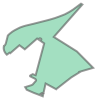

In [438]:
parks_shapes[0]

### Turning Distance Calcuation into Miles
This distance is in degrees. 1 degree latitude ~= to 69 miles. 1 degree longitude ~= 40 miles at NYC's latitude.

I'm going to treat a degree as equal to 54.5 miles, the average of the lengths of the two different kinds of degrees, for the purpose of these distance calculations. This means that my calculations of distance could be off by as much as 36.25%, if the change in position is actually only a change in longitude, latitude staying the same (in other words, 1 degree change actually equaling 40 miles). For a change only in latitude (longitude staying the same), the error rate is 21%.

Unfortunately, given the time line I'm on, I'm going to accept this level of imprecision. 

I tested the code on the following two entries from parks and from permits. My calculation of 14.13 miles is reasonably accurate.

I used [this website](https://www.mapdevelopers.com/distance_from_to.php) to the straight line distance between the two _addresses_ and got 16.67 miles, which is close. It's also important to note that the closest edge of the park is actually nearer to the site in permits than the location of the street address of the park. So it appears that this code is working in the right direction.

In [439]:
t0 = time.time()

for i in permits.index:
    t1 = time.time()
    print(f'Permit {i} started.')
    point = shapely.wkt.loads(permits['point'][i])
    close_park = 99999
    name_close_park = ''
    for n in range(0, len(parks_shapes)):
        distance = point.distance(parks_shapes[n])*54.5
        if distance < close_park:
            close_park = distance
            name_close_park = parks.loc[n, 'name311']
    permits.loc[i, 'closest_park'] = close_park
    permits.loc[i, 'name_closest_park'] = name_close_park
    print(f"Permit {i} finished at {time.time()}, after {time.time()-t1}, {time.time()-t0} since the start of the permit {i} code.")
print(f'Time to complete code: {time.time()-t0}') 

Permit 0 started.
Permit 0 finished at 1660330319.229462, after 0.02327585220336914, 0.023638010025024414 since the start of the permit 0 code.
Permit 1 started.
Permit 1 finished at 1660330319.2422469, after 0.012521028518676758, 0.0364232063293457 since the start of the permit 1 code.
Permit 2 started.
Permit 2 finished at 1660330319.253197, after 0.01085805892944336, 0.047369956970214844 since the start of the permit 2 code.
Permit 3 started.
Permit 3 finished at 1660330319.264846, after 0.011548757553100586, 0.05901789665222168 since the start of the permit 3 code.
Permit 4 started.
Permit 4 finished at 1660330319.275789, after 0.010887861251831055, 0.06996297836303711 since the start of the permit 4 code.
Permit 5 started.
Permit 5 finished at 1660330319.2886028, after 0.012711048126220703, 0.08277702331542969 since the start of the permit 5 code.
Permit 6 started.
Permit 6 finished at 1660330319.297923, after 0.009242773056030273, 0.09209704399108887 since the start of the permit

Looking at some of these to make sure they make sense... They line up. Interestingly, the Malls on Broadway are considered a park. So an address on Broadway is considered to be at a park.

In [440]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,point,in_nyc,in_borough,bct2020,total_complaints,closest_subway,closest_subway_line,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,in_hist_dist,closest_park,name_closest_park
0,MANHATTAN,1056547.0,2686,BROADWAY,121207354.0,10025.0,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740,POINT (-73.96874 40.798817),1.0,MANHATTAN,1019100.0,2255.0,0.033418,1,5.0,15.0,42.0,195.0,none,0.0,0.000000,Broadway Malls
1,MANHATTAN,1812187.0,140,HILLSIDE AVENUE,121189524.0,10040.0,2022-05-11,CORPORATION,N,40.860296,-73.926125,POINT (-73.926125 40.860296),1.0,MANHATTAN,1028300.0,701.0,0.085621,1,2.0,15.0,34.0,153.0,none,0.0,0.049425,Highbridge Park
2,BRONX,2823631.0,368,EAST 152 STREET,220586168.0,10455.0,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118,POINT (-73.918118 40.818565),1.0,BRONX,2006700.0,1578.0,0.167270,2-5,0.0,9.0,60.0,215.0,none,0.0,0.086285,Melrose Playground
3,BROOKLYN,3429007.0,3410,FARRAGUT ROAD,321588215.0,11210.0,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944,POINT (-73.943944 40.636513),1.0,BROOKLYN,3078400.0,293.0,0.318707,2-5,0.0,11.0,13.0,95.0,none,0.0,0.141644,Nostrand Playground
4,BROOKLYN,3121674.0,1457,FLATBUSH AVENUE,321827163.0,11210.0,2022-05-11,CORPORATION,N,40.634773,-73.949721,POINT (-73.949721 40.634773),1.0,BROOKLYN,3078601.0,642.0,0.147944,2-5,0.0,11.0,20.0,87.0,none,0.0,0.199042,Nostrand Playground


## Parks within a given radius

In [441]:
# note: the lati../backup_data/and longitude I'm using are in decimals NOT minutes, so I do the same here
# these are set at a tenth of a mile to start, with 1 degree lat = 69 miles and 1 degree longitude = 40 miles
max_delt_lat = 1/690 #CHANGE HERE
max_delt_long = 1/400 #CHANGE HERE

t0 = time.time()
print("Tenth mile started ", t0)
for i in permits.index:
    #lat = permits.loc[i, 'latitude']
    #long = permits.loc[i, 'longitude']
    #point1 = [lat, long]
    count = 0
    point = shapely.wkt.loads(permits.loc[i, 'point'])
    for n in range(0, len(parks_shapes)):
        distance = point.distance(parks_shapes[n])*54.5
        if distance < .1: # CHANGE HERE
            count += 1
    permits.loc[i, 'park_count_tenth_mi'] = count #CHANGE HERE

print("Time to run tenth mile:", time.time()-t0) #CHANGE HERE
print('')


max_delt_lat = 5/690 #CHANGE HERE
max_delt_long = 5/400 #CHANGE HERE

t0 = time.time()
print("Half mile started ", t0)
for i in permits.index:
    #lat = permits.loc[i, 'latitude']
    #long = permits.loc[i, 'longitude']
    #point1 = [lat, long]
    count = 0
    point = shapely.wkt.loads(permits.loc[i, 'point'])
    for n in range(0, len(parks_shapes)):
        distance = point.distance(parks_shapes[n])*54.5
        if distance < .5: # CHANGE HERE
            count += 1
    permits.loc[i, 'park_count_half_mi'] = count #CHANGE HERE

print("Time to run half mile:", time.time()-t0) #CHANGE HERE
print('')


max_delt_lat = 10/690 #CHANGE HERE
max_delt_long = 10/400 #CHANGE HERE

t0 = time.time()
print("Mile started ", t0)
for i in permits.index:
    #lat = permits.loc[i, 'latitude']
    #long = permits.loc[i, 'longitude']
    #point1 = [lat, long]
    count = 0
    point = shapely.wkt.loads(permits.loc[i, 'point'])
    for n in range(0, len(parks_shapes)):
        distance = point.distance(parks_shapes[n])*54.5
        if distance < 1: # CHANGE HERE
            count += 1
    permits.loc[i, 'park_count_one_mi'] = count #CHANGE HERE

print("Time to run one mile:", time.time()-t0) #CHANGE HERE
print('')

max_delt_lat = 25/690 #CHANGE HERE
max_delt_long = 25/400 #CHANGE HERE

t0 = time.time()
print("2.5 mile started ", t0)
for i in permits.index:
    #lat = permits.loc[i, 'latitude']
    #long = permits.loc[i, 'longitude']
    #point1 = [lat, long]
    count = 0
    point = shapely.wkt.loads(permits.loc[i, 'point'])
    for n in range(0, len(parks_shapes)):
        distance = point.distance(parks_shapes[n])*54.5
        if distance < 2.5: # CHANGE HERE
            count += 1
    permits.loc[i, 'park_count_two_five_mi'] = count #CHANGE HERE

print("Time to run 2.5 mile:", time.time()-t0) #CHANGE HERE
print('')

Tenth mile started  1660330408.559264
Time to run tenth mile: 56.34499406814575

Half mile started  1660330464.904531
Time to run half mile: 56.24313688278198

Mile started  1660330521.147857
Time to run one mile: 56.416903018951416

2.5 mile started  1660330577.5650291
Time to run 2.5 mile: 56.558727979660034



In [442]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,point,in_nyc,in_borough,bct2020,total_complaints,closest_subway,closest_subway_line,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,in_hist_dist,closest_park,name_closest_park,park_count_tenth_mi,park_count_half_mi,park_count_one_mi,park_count_two_five_mi
0,MANHATTAN,1056547.0,2686,BROADWAY,121207354.0,10025.0,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740,POINT (-73.96874 40.798817),1.0,MANHATTAN,1019100.0,2255.0,0.033418,1,5.0,15.0,42.0,195.0,none,0.0,0.000000,Broadway Malls,2.0,17.0,33.0,214.0
1,MANHATTAN,1812187.0,140,HILLSIDE AVENUE,121189524.0,10040.0,2022-05-11,CORPORATION,N,40.860296,-73.926125,POINT (-73.926125 40.860296),1.0,MANHATTAN,1028300.0,701.0,0.085621,1,2.0,15.0,34.0,153.0,none,0.0,0.049425,Highbridge Park,1.0,10.0,42.0,280.0
2,BRONX,2823631.0,368,EAST 152 STREET,220586168.0,10455.0,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118,POINT (-73.918118 40.818565),1.0,BRONX,2006700.0,1578.0,0.167270,2-5,0.0,9.0,60.0,215.0,none,0.0,0.086285,Melrose Playground,1.0,32.0,93.0,418.0
3,BROOKLYN,3429007.0,3410,FARRAGUT ROAD,321588215.0,11210.0,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944,POINT (-73.943944 40.636513),1.0,BROOKLYN,3078400.0,293.0,0.318707,2-5,0.0,11.0,13.0,95.0,none,0.0,0.141644,Nostrand Playground,0.0,3.0,15.0,153.0
4,BROOKLYN,3121674.0,1457,FLATBUSH AVENUE,321827163.0,11210.0,2022-05-11,CORPORATION,N,40.634773,-73.949721,POINT (-73.949721 40.634773),1.0,BROOKLYN,3078601.0,642.0,0.147944,2-5,0.0,11.0,20.0,87.0,none,0.0,0.199042,Nostrand Playground,0.0,3.0,14.0,127.0


In [443]:
permits.to_csv('../backup_data/perms_complaints_subway_histdistr_parks_backup.csv', index = False)

# Removing Bad Data
In my modeling work I discovered a data point with coordinates in Albany that somehow slipped through my tests in cleaning (hopefully no others did... I'll have to map to test.) The address is real. The long/lat is just wrong. Because I don't have time to clean it, I've eliminated it.

I then found a point in Nassau County, job no 540197785

In [444]:
permits[permits['job_no'] == 420658176]

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,point,in_nyc,in_borough,bct2020,total_complaints,closest_subway,closest_subway_line,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,in_hist_dist,closest_park,name_closest_park,park_count_tenth_mi,park_count_half_mi,park_count_one_mi,park_count_two_five_mi
7106,QUEENS,4623200.0,4,WILLIAMS COURT,420658176.0,11691.0,2019-05-02,INDIVIDUAL,N,40.599117,-73.749055,POINT (-73.749055 40.599117),1.0,QUEENS,4101004.0,0.0,0.494075,A,0.0,1.0,4.0,16.0,none,0.0,0.044861,Cornell Burial Ground,1.0,9.0,18.0,34.0


In [445]:
permits.shape

(7179, 30)

In [446]:
permits.drop(index = permits[permits['job_no'] == 420658176].index, inplace = True)

In [447]:
permits.shape

(7178, 30)

-----

In [448]:
permits[permits['job_no'] == 540197785]

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,point,in_nyc,in_borough,bct2020,total_complaints,closest_subway,closest_subway_line,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,in_hist_dist,closest_park,name_closest_park,park_count_tenth_mi,park_count_half_mi,park_count_one_mi,park_count_two_five_mi
7171,STATEN ISLAND,5171586.0,65,BUTLER PLACE,540197785.0,10305.0,2021-06-25,PARTNERSHIP,N,40.616066,-74.07047,POINT (-74.07046954545454 40.6160656969697),1.0,STATEN ISLAND,5000800.0,0.0,0.409104,SIR,0.0,2.0,3.0,21.0,none,0.0,0.081161,Kaltenmeier Playground,1.0,4.0,16.0,66.0


In [449]:
permits.shape

(7178, 30)

In [450]:
permits.drop(index = permits[permits['job_no'] == 540197785].index, inplace = True)

In [451]:
permits.shape

(7177, 30)

# Census Tract Data
I add details on the demographics of the census tract the permit falls in. For some of these, I use absolute numbers, and for sum, percentages. The percentages are represented out of 100, not 1, so I adjust accordingly.

In [452]:
census_data = pd.read_csv('data/cleaned_census_data.csv')

In [453]:
census_data.shape

(2327, 33)

In [454]:
census_data.head()

,geotype,borough,geoid,bct2020,pop_20,pop_20p,hhpop_20,hhpop_20p,gq_20,gq_20p,instgq_20,instgq_20p,avhhsz_20,popu18_20,popu18_20p,hsp_20,hsp_20p,wnh_20,wnh_20p,bnh_20,bnh_20p,anh_20,anh_20p,onh_20,onh_20p,nh2pl_20,nh2pl_20p,hunits_20,hunits_20p,ochu_20,ochu_20p,vachu_20,vachu_20p
0,CT2020,Bronx,36005000100,2000100,"3,772",1.0,27,0.007,"3,745",0.993,"3,745",0.993,0.00,12,0.003,"1,259",0.334,260,0.069,"2,172",0.576,59,0.016,12,0.003,10,0.003,1,1.0,0,0.000,1,1.000
1,CT2020,Bronx,36005000200,2000200,"4,779",1.0,"4,771",0.998,8,0.002,0,0.000,3.15,"1,065",0.223,"3,173",0.664,152,0.032,"1,011",0.212,202,0.042,115,0.024,126,0.026,"1,594",1.0,"1,517",0.952,77,0.048
2,CT2020,Bronx,36005000400,2000400,"6,272",1.0,"6,258",0.998,14,0.002,0,0.000,2.97,"1,337",0.213,"3,972",0.633,238,0.038,"1,592",0.254,230,0.037,91,0.015,149,0.024,"2,200",1.0,"2,110",0.959,90,0.041
3,CT2020,Bronx,36005001600,2001600,"5,795",1.0,"5,565",0.960,230,0.040,205,0.035,2.73,"1,251",0.216,"3,479",0.600,121,0.021,"1,884",0.325,122,0.021,81,0.014,108,0.019,"2,129",1.0,"2,042",0.959,87,0.041
4,CT2020,Bronx,36005001901,2001901,"2,292",1.0,"2,258",0.985,34,0.015,0,0.000,2.29,567,0.247,"1,089",0.475,250,0.109,803,0.350,39,0.017,35,0.015,76,0.033,"1,049",1.0,988,0.942,61,0.058


In [455]:
pd.set_option('display.max_columns', None)

In [456]:
to_use = ['bct2020', 'pop_20', 'hhpop_20p', 'gq_20p', 'instgq_20p', 'avhhsz_20', 'popu18_20p', 'hsp_20p', 'wnh_20p', 'bnh_20p', 'anh_20p', 'onh_20p', 'nh2pl_20p', 'hunits_20', 'ochu_20p', 'vachu_20p']


In [457]:
census_data.shape

(2327, 33)

In [458]:
census_data = census_data[to_use]

In [459]:
census_data.shape

(2327, 16)

In [460]:
permits['bct2020'] = permits['bct2020'].astype(int)

In [461]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,point,in_nyc,in_borough,bct2020,total_complaints,closest_subway,closest_subway_line,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,in_hist_dist,closest_park,name_closest_park,park_count_tenth_mi,park_count_half_mi,park_count_one_mi,park_count_two_five_mi
0,MANHATTAN,1056547.0,2686,BROADWAY,121207354.0,10025.0,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740,POINT (-73.96874 40.798817),1.0,MANHATTAN,1019100,2255.0,0.033418,1,5.0,15.0,42.0,195.0,none,0.0,0.000000,Broadway Malls,2.0,17.0,33.0,214.0
1,MANHATTAN,1812187.0,140,HILLSIDE AVENUE,121189524.0,10040.0,2022-05-11,CORPORATION,N,40.860296,-73.926125,POINT (-73.926125 40.860296),1.0,MANHATTAN,1028300,701.0,0.085621,1,2.0,15.0,34.0,153.0,none,0.0,0.049425,Highbridge Park,1.0,10.0,42.0,280.0
2,BRONX,2823631.0,368,EAST 152 STREET,220586168.0,10455.0,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118,POINT (-73.918118 40.818565),1.0,BRONX,2006700,1578.0,0.167270,2-5,0.0,9.0,60.0,215.0,none,0.0,0.086285,Melrose Playground,1.0,32.0,93.0,418.0
3,BROOKLYN,3429007.0,3410,FARRAGUT ROAD,321588215.0,11210.0,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944,POINT (-73.943944 40.636513),1.0,BROOKLYN,3078400,293.0,0.318707,2-5,0.0,11.0,13.0,95.0,none,0.0,0.141644,Nostrand Playground,0.0,3.0,15.0,153.0
4,BROOKLYN,3121674.0,1457,FLATBUSH AVENUE,321827163.0,11210.0,2022-05-11,CORPORATION,N,40.634773,-73.949721,POINT (-73.949721 40.634773),1.0,BROOKLYN,3078601,642.0,0.147944,2-5,0.0,11.0,20.0,87.0,none,0.0,0.199042,Nostrand Playground,0.0,3.0,14.0,127.0


In [462]:
permits = permits.merge(census_data, on= 'bct2020')

In [463]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,point,in_nyc,in_borough,bct2020,total_complaints,closest_subway,closest_subway_line,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,in_hist_dist,closest_park,name_closest_park,park_count_tenth_mi,park_count_half_mi,park_count_one_mi,park_count_two_five_mi,pop_20,hhpop_20p,gq_20p,instgq_20p,avhhsz_20,popu18_20p,hsp_20p,wnh_20p,bnh_20p,anh_20p,onh_20p,nh2pl_20p,hunits_20,ochu_20p,vachu_20p
0,MANHATTAN,1056547.0,2686,BROADWAY,121207354.0,10025.0,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740,POINT (-73.96874 40.798817),1.0,MANHATTAN,1019100,2255.0,0.033418,1,5.0,15.0,42.0,195.0,none,0.0,0.000000,Broadway Malls,2.0,17.0,33.0,214.0,"9,005",0.963,0.037,0.0,1.89,0.129,0.159,0.614,0.081,0.099,0.008,0.040,"4,951",0.924,0.076
1,MANHATTAN,1812187.0,140,HILLSIDE AVENUE,121189524.0,10040.0,2022-05-11,CORPORATION,N,40.860296,-73.926125,POINT (-73.926125 40.860296),1.0,MANHATTAN,1028300,701.0,0.085621,1,2.0,15.0,34.0,153.0,none,0.0,0.049425,Highbridge Park,1.0,10.0,42.0,280.0,"7,740",0.998,0.002,0.0,2.30,0.153,0.673,0.189,0.066,0.041,0.009,0.022,"3,517",0.957,0.043
2,MANHATTAN,1091669.0,37,HILLSIDE AVENUE,121205445.0,10040.0,2021-02-19,PARTNERSHIP,N,40.858508,-73.929532,POINT (-73.929532 40.858508),1.0,MANHATTAN,1028300,546.0,0.177308,A,0.0,6.0,35.0,146.0,none,0.0,0.115871,Fort Tryon Park,0.0,11.0,41.0,275.0,"7,740",0.998,0.002,0.0,2.30,0.153,0.673,0.189,0.066,0.041,0.009,0.022,"3,517",0.957,0.043
3,BRONX,2823631.0,368,EAST 152 STREET,220586168.0,10455.0,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118,POINT (-73.918118 40.818565),1.0,BRONX,2006700,1578.0,0.167270,2-5,0.0,9.0,60.0,215.0,none,0.0,0.086285,Melrose Playground,1.0,32.0,93.0,418.0,"6,893",0.979,0.021,0.0,2.85,0.264,0.710,0.017,0.245,0.008,0.010,0.011,"2,439",0.970,0.030
4,BRONX,2129278.0,418,EAST 153 STREET,220593463.0,10455.0,2018-02-09,CORPORATION,N,40.818742,-73.915997,POINT (-73.915997 40.818742),1.0,BRONX,2006700,2368.0,0.196656,2-5,0.0,12.0,61.0,216.0,none,0.0,0.134117,P.S. 29 Ballfield,0.0,32.0,90.0,422.0,"6,893",0.979,0.021,0.0,2.85,0.264,0.710,0.017,0.245,0.008,0.010,0.011,"2,439",0.970,0.030


In [464]:
permits.to_csv('../backup_data/perms_before_drop_dummify3_w_census.csv', index = False)

In [475]:
permits.to_csv('data/perms_w_features_for_eda.csv', index = False)

# Dummify Variables

In [465]:
# permits = pd.read_csv('../backup_data/perms_before_drop_dummify3_w_census.csv')

Getting DataTypes correct (including for those that I'm not dummifying)

In [466]:
permits['zip_code'] = permits['zip_code'].astype(int)

In [467]:
permits['zip_code'].dtype

dtype('int64')

In [468]:
permits['pop_20'] = permits['pop_20'].map(lambda x: x.replace(',', ''))
permits['hunits_20'] = permits['hunits_20'].map(lambda x: x.replace(',', ''))

In [469]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,point,in_nyc,in_borough,bct2020,total_complaints,closest_subway,closest_subway_line,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,in_hist_dist,closest_park,name_closest_park,park_count_tenth_mi,park_count_half_mi,park_count_one_mi,park_count_two_five_mi,pop_20,hhpop_20p,gq_20p,instgq_20p,avhhsz_20,popu18_20p,hsp_20p,wnh_20p,bnh_20p,anh_20p,onh_20p,nh2pl_20p,hunits_20,ochu_20p,vachu_20p
0,MANHATTAN,1056547.0,2686,BROADWAY,121207354.0,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740,POINT (-73.96874 40.798817),1.0,MANHATTAN,1019100,2255.0,0.033418,1,5.0,15.0,42.0,195.0,none,0.0,0.000000,Broadway Malls,2.0,17.0,33.0,214.0,9005,0.963,0.037,0.0,1.89,0.129,0.159,0.614,0.081,0.099,0.008,0.040,4951,0.924,0.076
1,MANHATTAN,1812187.0,140,HILLSIDE AVENUE,121189524.0,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125,POINT (-73.926125 40.860296),1.0,MANHATTAN,1028300,701.0,0.085621,1,2.0,15.0,34.0,153.0,none,0.0,0.049425,Highbridge Park,1.0,10.0,42.0,280.0,7740,0.998,0.002,0.0,2.30,0.153,0.673,0.189,0.066,0.041,0.009,0.022,3517,0.957,0.043
2,MANHATTAN,1091669.0,37,HILLSIDE AVENUE,121205445.0,10040,2021-02-19,PARTNERSHIP,N,40.858508,-73.929532,POINT (-73.929532 40.858508),1.0,MANHATTAN,1028300,546.0,0.177308,A,0.0,6.0,35.0,146.0,none,0.0,0.115871,Fort Tryon Park,0.0,11.0,41.0,275.0,7740,0.998,0.002,0.0,2.30,0.153,0.673,0.189,0.066,0.041,0.009,0.022,3517,0.957,0.043
3,BRONX,2823631.0,368,EAST 152 STREET,220586168.0,10455,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118,POINT (-73.918118 40.818565),1.0,BRONX,2006700,1578.0,0.167270,2-5,0.0,9.0,60.0,215.0,none,0.0,0.086285,Melrose Playground,1.0,32.0,93.0,418.0,6893,0.979,0.021,0.0,2.85,0.264,0.710,0.017,0.245,0.008,0.010,0.011,2439,0.970,0.030
4,BRONX,2129278.0,418,EAST 153 STREET,220593463.0,10455,2018-02-09,CORPORATION,N,40.818742,-73.915997,POINT (-73.915997 40.818742),1.0,BRONX,2006700,2368.0,0.196656,2-5,0.0,12.0,61.0,216.0,none,0.0,0.134117,P.S. 29 Ballfield,0.0,32.0,90.0,422.0,6893,0.979,0.021,0.0,2.85,0.264,0.710,0.017,0.245,0.008,0.010,0.011,2439,0.970,0.030


In [470]:
permits['bin_no'] = permits['bin_no'].astype(int)
permits['job_no'] = permits['job_no'].astype(int)

permits['in_hist_dist'] = permits['in_hist_dist'].astype(int)

permits['subway_count_tenth_mi'] = permits['subway_count_tenth_mi'].astype(int)
permits['subway_count_half_mi'] = permits['subway_count_half_mi'].astype(int)
permits['subway_count_one_mi'] = permits['subway_count_one_mi'].astype(int)
permits['subway_count_two_five_mi'] = permits['subway_count_two_five_mi'].astype(int)

permits['park_count_tenth_mi'] = permits['park_count_tenth_mi'].astype(int)
permits['park_count_half_mi'] = permits['park_count_half_mi'].astype(int)
permits['park_count_one_mi'] = permits['park_count_one_mi'].astype(int)
permits['park_count_two_five_mi'] = permits['park_count_two_five_mi'].astype(int)

#I leave these for now in case they're not eliminated the before this point
#permits['complaints2014_15'] = permits['complaints2014_15'].astype(int)
#permits['complaints2015_16'] = permits['complaints2015_16'].astype(int)
#permits['complaints2016_17'] = permits['complaints2016_17'].astype(int)
#permits['complaints2017_18'] = permits['complaints2017_18'].astype(int)
#permits['complaints2018_19'] = permits['complaints2018_19'].astype(int)
#permits['complaints2019_20'] = permits['complaints2019_20'].astype(int)
permits['total_complaints'] = permits['total_complaints'].astype(int)

permits['pop_20'] = permits['pop_20'].astype(int)
permits['hunits_20'] = permits['hunits_20'].astype(int)

In [471]:
permits.dtypes

borough                      object
bin_no                        int64
house_no                     object
street_name                  object
job_no                        int64
zip_code                      int64
job_start_date               object
owners_business_type         object
non-profit                   object
latitude                    float64
longitude                   float64
point                        object
in_nyc                      float64
in_borough                   object
bct2020                       int64
total_complaints              int64
closest_subway              float64
closest_subway_line          object
subway_count_tenth_mi         int64
subway_count_half_mi          int64
subway_count_one_mi           int64
subway_count_two_five_mi      int64
hist_dist_name               object
in_hist_dist                  int64
closest_park                float64
name_closest_park            object
park_count_tenth_mi           int64
park_count_half_mi          

In [472]:
# pd.set_option('display.max_columns', None)

We don't need the 'point' any more, so dropping that.

In [476]:
permits.drop(columns = 'point', inplace = True)

In [477]:
permits['in_nyc'].value_counts()

1.0    7177
Name: in_nyc, dtype: int64

In [479]:
permits['in_borough'].value_counts()

BROOKLYN         2196
QUEENS           2074
STATEN ISLAND    1896
BRONX             731
MANHATTAN         280
Name: in_borough, dtype: int64

In [480]:
permits['borough'].value_counts()

BROOKLYN         2196
QUEENS           2074
STATEN ISLAND    1896
BRONX             731
MANHATTAN         280
Name: borough, dtype: int64

In [481]:
permits[permits['in_borough'] != permits['borough']]

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,in_nyc,in_borough,bct2020,total_complaints,closest_subway,closest_subway_line,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,in_hist_dist,closest_park,name_closest_park,park_count_tenth_mi,park_count_half_mi,park_count_one_mi,park_count_two_five_mi,pop_20,hhpop_20p,gq_20p,instgq_20p,avhhsz_20,popu18_20p,hsp_20p,wnh_20p,bnh_20p,anh_20p,onh_20p,nh2pl_20p,hunits_20,ochu_20p,vachu_20p


In [483]:
permits.shape

(7177, 44)

In [484]:
permits.drop(columns = ['in_borough', 'in_nyc'], inplace = True)

In [485]:
permits.shape

(7177, 42)

-----

## Dummifying

In [486]:
permits_dummies = pd.get_dummies(columns = ['borough', 'owners_business_type', 'non-profit', 'in_hist_dist', 'bct2020'], drop_first = True, data = permits)
permits_dummies.head()

,bin_no,house_no,street_name,job_no,zip_code,job_start_date,latitude,longitude,total_complaints,closest_subway,closest_subway_line,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,closest_park,name_closest_park,park_count_tenth_mi,park_count_half_mi,park_count_one_mi,park_count_two_five_mi,pop_20,hhpop_20p,gq_20p,instgq_20p,avhhsz_20,popu18_20p,hsp_20p,wnh_20p,bnh_20p,anh_20p,onh_20p,nh2pl_20p,hunits_20,ochu_20p,vachu_20p,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,owners_business_type_CORPORATION,owners_business_type_HPD,owners_business_type_INDIVIDUAL,owners_business_type_NYC AGENCY,owners_business_type_NYCHA/HHC,owners_business_type_OTHER,owners_business_type_OTHER GOV'T AGENCY,owners_business_type_PARTNERSHIP,non-profit_Y,in_hist_dist_1,bct2020_1001200,bct2020_1001402,bct2020_1001501,bct2020_1001502,bct2020_1001600,bct2020_1001800,bct2020_1002100,bct2020_1002201,bct2020_1002202,bct2020_1002601,bct2020_1002602,bct2020_1002800,bct2020_1003001,bct2020_1003002,bct2020_1003300,bct2020_1003400,bct2020_1003601,bct2020_1003602,bct2020_1003700,bct2020_1003800,bct2020_1003900,bct2020_1004100,bct2020_1004200,bct2020_1004300,bct2020_1004500,bct2020_1004700,bct2020_1005400,bct2020_1005502,bct2020_1005800,bct2020_1006400,bct2020_1006800,bct2020_1006900,bct2020_1007002,bct2020_1007100,bct2020_1007300,bct2020_1007400,bct2020_1007500,bct2020_1007800,bct2020_1008100,bct2020_1008700,bct2020_1008800,bct2020_1008900,bct2020_1009100,bct2020_1009500,bct2020_1009700,bct2020_1009800,bct2020_1009901,bct2020_1009902,bct2020_1009903,bct2020_1010000,bct2020_1011100,bct2020_1011201,bct2020_1011500,bct2020_1012101,bct2020_1012700,bct2020_1012901,bct2020_1012902,bct2020_1013201,bct2020_1013300,bct2020_1013501,bct2020_1013502,bct2020_1013602,bct2020_1013800,bct2020_1013900,bct2020_1014000,bct2020_1014200,bct2020_1014402,bct2020_1014500,bct2020_1014601,bct2020_1014801,bct2020_1014802,bct2020_1014900,bct2020_1015001,bct2020_1015002,bct2020_1015102,bct2020_1015200,bct2020_1015402,bct2020_1015501,bct2020_1015601,bct2020_1015900,bct2020_1016200,bct2020_1016400,bct2020_1016600,bct2020_1016700,bct2020_1016900,bct2020_1017000,bct2020_1017200,bct2020_1017401,bct2020_1017402,bct2020_1017500,bct2020_1017800,bct2020_1017900,bct2020_1018000,bct2020_1018100,bct2020_1018200,bct2020_1018300,bct2020_1018600,bct2020_1018700,bct2020_1018800,bct2020_1018900,bct2020_1019000,bct2020_1019100,bct2020_1019200,bct2020_1019300,bct2020_1019400,bct2020_1019600,bct2020_1019702,bct2020_1019800,bct2020_1020000,bct2020_1020102,bct2020_1020500,bct2020_1020600,bct2020_1020701,bct2020_1020800,bct2020_1020901,bct2020_1021100,bct2020_1021303,bct2020_1021500,bct2020_1021800,bct2020_1021900,bct2020_1022102,bct2020_1022200,bct2020_1022400,bct2020_1022600,bct2020_1022700,bct2020_1022800,bct2020_1023000,bct2020_1023100,bct2020_1023200,bct2020_1023300,bct2020_1023400,bct2020_1023501,bct2020_1023502,bct2020_1023600,bct2020_1023700,bct2020_1023804,bct2020_1024200,bct2020_1024301,bct2020_1024500,bct2020_1025100,bct2020_1025700,bct2020_1025900,bct2020_1026900,bct2020_1027300,bct2020_1027900,bct2020_1028300,bct2020_1028700,bct2020_1029100,bct2020_1029500,bct2020_2000200,bct2020_2000400,bct2020_2001600,bct2020_2001901,bct2020_2001902,bct2020_2002001,bct2020_2002002,bct2020_2002500,bct2020_2002701,bct2020_2002800,bct2020_2003100,bct2020_2003300,bct2020_2003500,bct2020_2003800,bct2020_2004100,bct2020_2004300,bct2020_2004400,bct2020_2005002,bct2020_2005100,bct2020_2005902,bct2020_2006301,bct2020_2006400,bct2020_2006500,bct2020_2006700,bct2020_2006900,bct2020_2007000,bct2020_2007100,bct2020_2007300,bct2020_2007500,bct2020_2007600,bct2020_2007700,bct2020_2007800,bct2020_2007900,bct2020_2008700,bct2020_2008900,bct2020_2009000,bct2020_2009200,bct2020_2009301,bct2020_2009600,bct2020_2011502,bct2020_2011800,bct2020_2012101,bct2020_2012102,bct2020_2012300,bct2020_2012500,bct2020_2012701,bct2020_2012901,bct2020_2013000,bct2020_2013100

In [487]:
permits_dum_nobct2020 = pd.get_dummies(columns = ['borough', 'owners_business_type', 'non-profit', 'in_hist_dist'], drop_first = True, data = permits)
permits_dum_nobct2020.head()

,bin_no,house_no,street_name,job_no,zip_code,job_start_date,latitude,longitude,bct2020,total_complaints,closest_subway,closest_subway_line,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,closest_park,name_closest_park,park_count_tenth_mi,park_count_half_mi,park_count_one_mi,park_count_two_five_mi,pop_20,hhpop_20p,gq_20p,instgq_20p,avhhsz_20,popu18_20p,hsp_20p,wnh_20p,bnh_20p,anh_20p,onh_20p,nh2pl_20p,hunits_20,ochu_20p,vachu_20p,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,owners_business_type_CORPORATION,owners_business_type_HPD,owners_business_type_INDIVIDUAL,owners_business_type_NYC AGENCY,owners_business_type_NYCHA/HHC,owners_business_type_OTHER,owners_business_type_OTHER GOV'T AGENCY,owners_business_type_PARTNERSHIP,non-profit_Y,in_hist_dist_1
0,1056547,2686,BROADWAY,121207354,10025,2022-05-11,40.798817,-73.968740,1019100,2255,0.033418,1,5,15,42,195,none,0.000000,Broadway Malls,2,17,33,214,9005,0.963,0.037,0.0,1.89,0.129,0.159,0.614,0.081,0.099,0.008,0.040,4951,0.924,0.076,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,40.860296,-73.926125,1028300,701,0.085621,1,2,15,34,153,none,0.049425,Highbridge Park,1,10,42,280,7740,0.998,0.002,0.0,2.30,0.153,0.673,0.189,0.066,0.041,0.009,0.022,3517,0.957,0.043,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,1091669,37,HILLSIDE AVENUE,121205445,10040,2021-02-19,40.858508,-73.929532,1028300,546,0.177308,A,0,6,35,146,none,0.115871,Fort Tryon Park,0,11,41,275,7740,0.998,0.002,0.0,2.30,0.153,0.673,0.189,0.066,0.041,0.009,0.022,3517,0.957,0.043,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,2823631,368,EAST 152 STREET,220586168,10455,2022-05-11,40.818565,-73.918118,2006700,1578,0.167270,2-5,0,9,60,215,none,0.086285,Melrose Playground,1,32,93,418,6893,0.979,0.021,0.0,2.85,0.264,0.710,0.017,0.245,0.008,0.010,0.011,2439,0.970,0.030,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2129278,418,EAST 153 STREET,220593463,10455,2018-02-09,40.818742,-73.915997,2006700,2368,0.196656,2-5,0,12,61,216,none,0.134117,P.S. 29 Ballfield,0,32,90,422,6893,0.979,0.021,0.0,2.85,0.264,0.710,0.017,0.245,0.008,0.010,0.011,2439,0.970,0.030,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [488]:
permits_dum_for_testing = pd.get_dummies(columns = ['borough', 'in_hist_dist'], drop_first = True, data = permits)
permits_dum_for_testing.head()

,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,bct2020,total_complaints,closest_subway,closest_subway_line,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,closest_park,name_closest_park,park_count_tenth_mi,park_count_half_mi,park_count_one_mi,park_count_two_five_mi,pop_20,hhpop_20p,gq_20p,instgq_20p,avhhsz_20,popu18_20p,hsp_20p,wnh_20p,bnh_20p,anh_20p,onh_20p,nh2pl_20p,hunits_20,ochu_20p,vachu_20p,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,in_hist_dist_1
0,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740,1019100,2255,0.033418,1,5,15,42,195,none,0.000000,Broadway Malls,2,17,33,214,9005,0.963,0.037,0.0,1.89,0.129,0.159,0.614,0.081,0.099,0.008,0.040,4951,0.924,0.076,0,1,0,0,0
1,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125,1028300,701,0.085621,1,2,15,34,153,none,0.049425,Highbridge Park,1,10,42,280,7740,0.998,0.002,0.0,2.30,0.153,0.673,0.189,0.066,0.041,0.009,0.022,3517,0.957,0.043,0,1,0,0,0
2,1091669,37,HILLSIDE AVENUE,121205445,10040,2021-02-19,PARTNERSHIP,N,40.858508,-73.929532,1028300,546,0.177308,A,0,6,35,146,none,0.115871,Fort Tryon Park,0,11,41,275,7740,0.998,0.002,0.0,2.30,0.153,0.673,0.189,0.066,0.041,0.009,0.022,3517,0.957,0.043,0,1,0,0,0
3,2823631,368,EAST 152 STREET,220586168,10455,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118,2006700,1578,0.167270,2-5,0,9,60,215,none,0.086285,Melrose Playground,1,32,93,418,6893,0.979,0.021,0.0,2.85,0.264,0.710,0.017,0.245,0.008,0.010,0.011,2439,0.970,0.030,0,0,0,0,0
4,2129278,418,EAST 153 STREET,220593463,10455,2018-02-09,CORPORATION,N,40.818742,-73.915997,2006700,2368,0.196656,2-5,0,12,61,216,none,0.134117,P.S. 29 Ballfield,0,32,90,422,6893,0.979,0.021,0.0,2.85,0.264,0.710,0.017,0.245,0.008,0.010,0.011,2439,0.970,0.030,0,0,0,0,0


## EXPORTING

In [489]:
permits_dummies.to_csv('data/final_permits.csv', index = False)

In [490]:
permits_dum_nobct2020.to_csv('data/final_permits_nobct2020.csv', index = False)

In [491]:
permits_dum_for_testing.to_csv('data/final_permits_for_testing.csv', index = False)

-----

-----

----

# This Shouldn't Be Necessary
I discovered data points that fell outside NYC after I reached this point, so I went back and eliminated them here after I wrote the code to fix that element in the cleaning stage, so I wouldn't need to rerun everything. If you ran this code after 8/11/2022, that change was made and this shouldn't be necessary.

In [358]:
permits.shape

(7176, 30)

In [372]:
permits[permits['job_no']==420663712]

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,in_hist_dist,park_count_tenth_mi,park_count_half_mi,park_count_one_mi,park_count_two_five_mi,closest_park,name_closest_park,complaints2014_15,complaints2015_16,complaints2016_17,complaints2017_18,complaints2018_19,complaints2019_20,total_complaints
7014,QUEENS,4623326,1725,VILLAGE LANE,420663712,11691,2019-06-12,PARTNERSHIP,N,40.99933,-72.528094,0,0,0,0,none,0,0,0,0,0,65.846407,Playground Eighty LXXX,0,0,0,0,0,0,0


In [384]:
drop_list = [420663712,
 420663589,
 420858405,
 520363071,
 520363080,
 520363099,
 420663570,
 420667558]

In [379]:
permits.drop(permits[permits['job_no'] == 420667558].index).shape

(7175, 30)

In [387]:
drop_list

[420663712,
 420663589,
 420858405,
 520363071,
 520363080,
 520363099,
 420663570,
 420667558]

In [388]:
for num in drop_list:
    print(num)
    permits.drop(permits[permits['job_no'] == num].index, inplace = True)

420663712
420663589
420858405
520363071
520363080
520363099
420663570
420667558


In [389]:
permits.shape

(7168, 30)

# This Also Shouldn't Be Necessary
I brought in the census tract information after I'd done a lot of time consuming work, so I'm attaching it here.

I also need to eliminate the 6 elements that I saved after having done that work, 8/11/22: [321112862, 520287010, 321547215, 220635212, 440664504, 520228584]

In [5]:
census_tract_data = pd.read_csv('data/cleaned_permits.csv')

In [6]:
census_tract_data.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,point,in_nyc,in_borough,bct2020
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740,POINT (-73.96874 40.798817),1,MANHATTAN,1019100
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125,POINT (-73.926125 40.860296),1,MANHATTAN,1028300
2,BRONX,2823631,368,EAST 152 STREET,220586168,10455,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118,POINT (-73.918118 40.818565),1,BRONX,2006700
3,BROOKLYN,3429007,3410,FARRAGUT ROAD,321588215,11210,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944,POINT (-73.943944 40.636513),1,BROOKLYN,3078400
4,BROOKLYN,3121674,1457,FLATBUSH AVENUE,321827163,11210,2022-05-11,CORPORATION,N,40.634773,-73.949721,POINT (-73.949721 40.634773),1,BROOKLYN,3078601


In [7]:
census_tract_data = census_tract_data[['job_no', 'bct2020']]

In [11]:
census_tract_data.shape

(7174, 2)

In [10]:
drop_list = [321112862, 520287010, 321547215, 220635212, 440664504, 520228584]

In [12]:
for num in drop_list:
    print(num)
    census_tract_data.drop(census_tract_data[census_tract_data['job_no'] == num].index, inplace = True)

321112862
520287010
321547215
220635212
440664504
520228584


In [13]:
census_tract_data.shape

(7168, 2)

In [15]:
permits = permits.merge(census_tract_data, on = 'job_no')

In [16]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,...,closest_park,name_closest_park,complaints2014_15,complaints2015_16,complaints2016_17,complaints2017_18,complaints2018_19,complaints2019_20,total_complaints,bct2020
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,...,0.000000,Broadway Malls,346.0,392.0,358.0,428.0,365.0,366.0,2255.0,1019100
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,...,0.049425,Highbridge Park,145.0,140.0,116.0,115.0,94.0,91.0,701.0,1028300
2,BRONX,2823631,368,EAST 152 STREET,220586168,10455,2022-05-11,INDIVIDUAL,N,40.818565,...,0.086285,Melrose Playground,291.0,327.0,254.0,240.0,243.0,223.0,1578.0,2006700
3,BROOKLYN,3429007,3410,FARRAGUT ROAD,321588215,11210,2022-05-18,INDIVIDUAL,N,40.636513,...,0.141644,Nostrand Playground,66.0,50.0,44.0,45.0,56.0,32.0,293.0,3078400
4,BROOKLYN,3121674,1457,FLATBUSH AVENUE,321827163,11210,2022-05-11,CORPORATION,N,40.634773,...,0.199042,Nostrand Playground,126.0,117.0,103.0,107.0,100.0,89.0,642.0,3078601
